In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

def load_data() -> dict[str, pd.DataFrame]:
	"""
	Load data from CSV files in the 'csv' directory and return a dictionary of DataFrames.

	Returns:
		dict[str, pd.DataFrame]: A dictionary where the keys are the names of the CSV files
		(extracted from the file names) and the values are the corresponding DataFrames.
	"""
	data = {}
	for file in os.listdir("csv"):
		if file.startswith("predictions"):
			name = file.split("_")[1:]
			name = "_".join(name).split(".")[0]
			data[name] = pd.read_csv("csv/" + file)
	return data

In [2]:
dfs = load_data()
print(dfs.keys())
# define colors for each model
COLORS = sns.color_palette(n_colors= len(dfs.keys()))
dfs_corr = {key: df for key, df in dfs.items() if key.endswith("corr")}
dfs = {key: df for key, df in dfs.items() if not key.endswith("corr")}
for idx, (key, df) in enumerate(dfs.items()):
	# add color column to the DataFrame (is a tuple of RGB values)
	df["r"] = COLORS[idx][0]
	df["g"] = COLORS[idx][1]
	df["b"] = COLORS[idx][2]
	
for idx, (key, df) in enumerate(dfs_corr.items()):
	# add color column to the DataFrame (is a tuple of RGB values)
	df["r"] = COLORS[idx+4][0]
	df["g"] = COLORS[idx+4][1]
	df["b"] = COLORS[idx+4][2]

# concatenate dfs and dfs_corr
dfs = dfs | dfs_corr

dict_keys(['ensemble', 'ensemble_mcdropout', 'feedforward', 'feedforward_corr', 'lr', 'lr_corr', 'lr_time_only', 'mcdropout', 'rtdhw', 'tabnet', 'xgboost', 'xgboost_corr'])


In [3]:
def calculate_metrics(dfs: dict[str, pd.DataFrame]):
	metrics = {}
	for model_name, df in dfs.items():
		predictions = df["predictions"]
		actuals = df["actual"]

		errors = predictions - actuals
		mape = (errors.abs() / actuals.abs()).mean() * 100
		std = (errors.abs() / actuals.abs()).std() * 100

		metrics[model_name] = {"MAPE": mape, "STD": std, "color": (df["r"].iloc[0], df["g"].iloc[0], df["b"].iloc[0])}
	
	return metrics

def plot_MAPE(metrics, std: bool = True):
	df_metrics = pd.DataFrame(metrics).T
	fig, ax = plt.subplots(figsize=(12, 8))
	
	df_metrics = df_metrics.sort_values('MAPE', ascending=False)
	colors = df_metrics['color']
	if std:
		bars = ax.barh(df_metrics.index, df_metrics['MAPE'], xerr=df_metrics['STD'], capsize=4, color=colors)
	else:
		bars = ax.barh(df_metrics.index, df_metrics['MAPE'], color=colors)
	ax.set_xlabel('MAPE (%)')
	ax.set_title('Model Metrics')

	if std:
		for bar, std in zip(bars, df_metrics['STD']):
			width = bar.get_width()
			ax.text(width * 1.001, bar.get_y() + bar.get_height() / 2 * 1.25, f'{std:.2f}', ha='left', va='center')
	else:
		for bar in bars:
			width = bar.get_width()
			ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', ha='left', va='center')

	plt.grid(axis='x', linestyle='--', alpha=0.6)
	plt.show()

def plot_errors(dfs: dict[str, pd.DataFrame], log_scale: bool = False, models: list[str] = None, figsize: tuple = (12,6)):
	plt.figure(figsize=figsize)
	models = models or dfs.keys()
	bar_width = 1 / (len(models)+1)
	idx = 0
	bins = None
	max_height = 0
	for model_name, df in dfs.items():
		if models and model_name not in models:
			continue
		df = dfs[model_name]
		errors = df["predictions"] - df["actual"]
		df["mape"] = (errors.abs() / df["actual"].abs()) * 100
		if log_scale:
			bins = np.logspace(np.log10(df["actual"].min()), np.log10(df["actual"].max()), 15)
		else:
			bins = np.linspace(df["actual"].min(), df["actual"].max(), 15)
		df["time_bins"] = pd.cut(df["actual"], bins)
		cum_mape = df.groupby("time_bins", observed=False)["mape"].mean()
		max_height = max(max_height, cum_mape.max())
		
		bin_centers = (bins[:-1] + bins[1:]) / 2
		bar_positions = bin_centers + (idx - len(models) / 2+0.5) * (np.diff(bins) * bar_width)
		plt.bar(bar_positions, cum_mape, width=np.diff(bins)*bar_width, label=model_name,align="center", color=(df["r"].iloc[0], df["g"].iloc[0], df["b"].iloc[0]))
		idx += 1
	
	xticks = []
	bars = plt.bar(bin_centers, cum_mape, width=np.diff(bins), facecolor='none', edgecolor='none', align="center")
	plt.vlines(bars[0].get_x(), ymin=0, ymax=1.5, color='black', linewidth=1)
	xticks.append(bars[0].get_x())
	for bar in bars:
		plt.vlines(bar.get_x() + bar.get_width(), ymin=0, ymax=1.5, color='black', linewidth=1)
		xticks.append(bar.get_x() + bar.get_width())


	if log_scale:
		plt.xscale("log")
		plt.gca().set_xticks(bins, minor=True)
		plt.gca().set_xticklabels([f"{x:.2f}" for x in bins], minor=True, ha='center')
		plt.gca().tick_params(axis='x', which='minor', bottom=True, top=False, labelbottom=True, labeltop=False)
		plt.gca().tick_params(axis='x', which='major', top=True, bottom=False, labelbottom=False, labeltop=True, direction='inout')
		plt.xlabel("Total Time Target (log scale)")
	else:
		plt.xticks(xticks, [f"{int(x):,}" for x in bins])
		plt.xlabel("Total Time Target")
	plt.ylabel("Mean MAPE")
	plt.title("Mean MAPE vs Total Time Target")
	plt.legend(loc="upper right")
	plt.grid(axis='y', linestyle='--', alpha=0.6)
	plt.show()

# MAPE

In [4]:
# borrar keys que terminen en "corr"
dfs_corr = {
	"feedforward_corr": dfs["feedforward_corr"].copy(), "feedforward": dfs["feedforward"], 
	"lr_corr": dfs["lr_corr"].copy(), "lr": dfs["lr"],
	"xgboost_corr": dfs["xgboost_corr"].copy(), "xgboost": dfs["xgboost"]	
}
del dfs["feedforward_corr"]
del dfs["lr_corr"]
del dfs["xgboost_corr"]

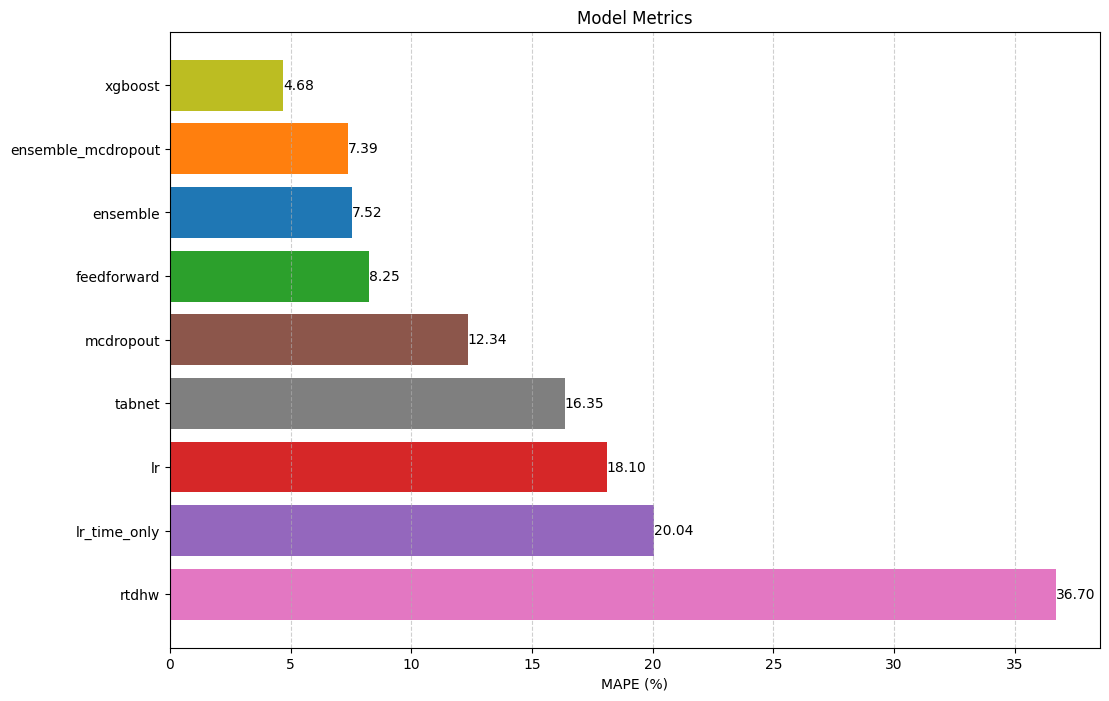

In [5]:
metrics = calculate_metrics(dfs)
plot_MAPE(metrics, std=False)

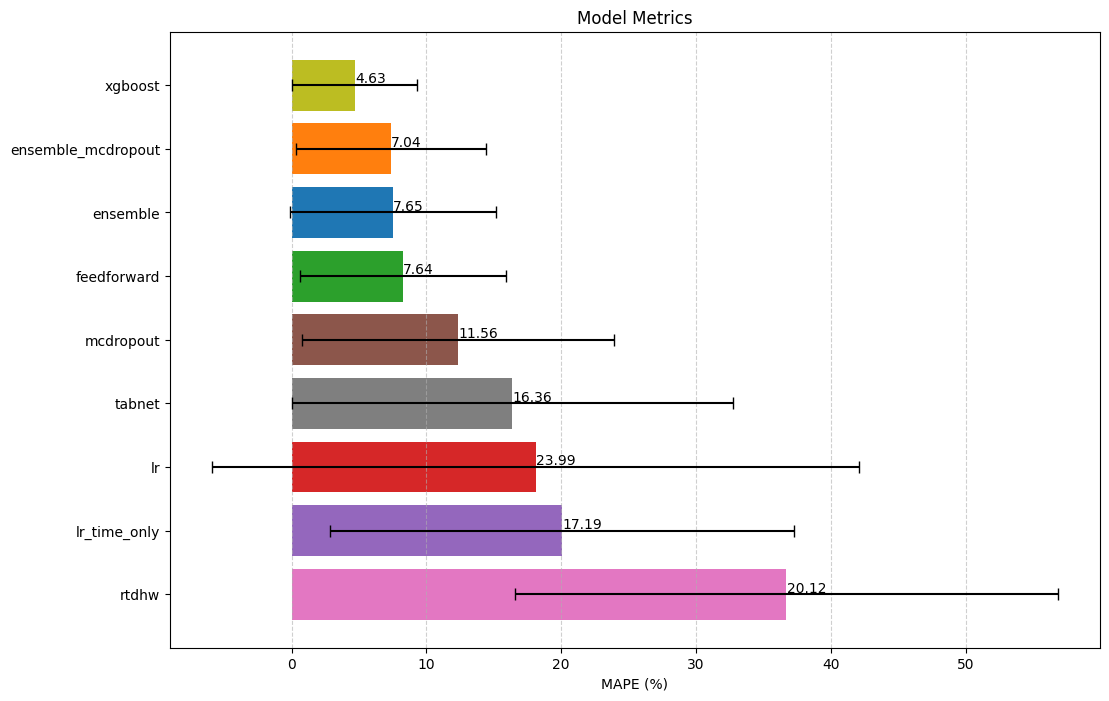

In [6]:
plot_MAPE(metrics)

# Errors

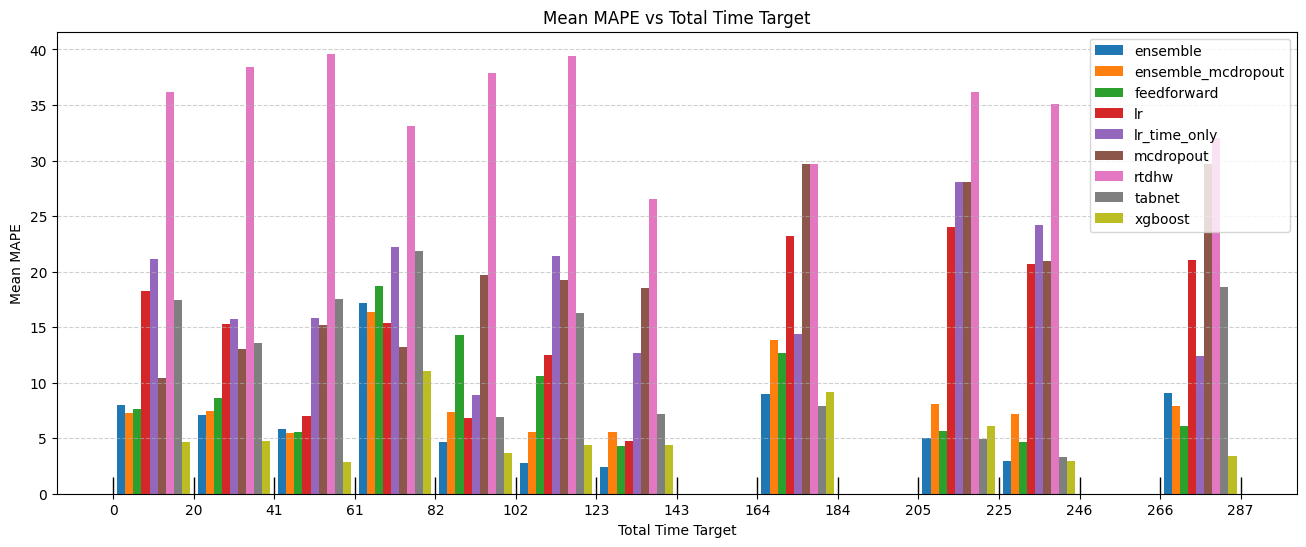

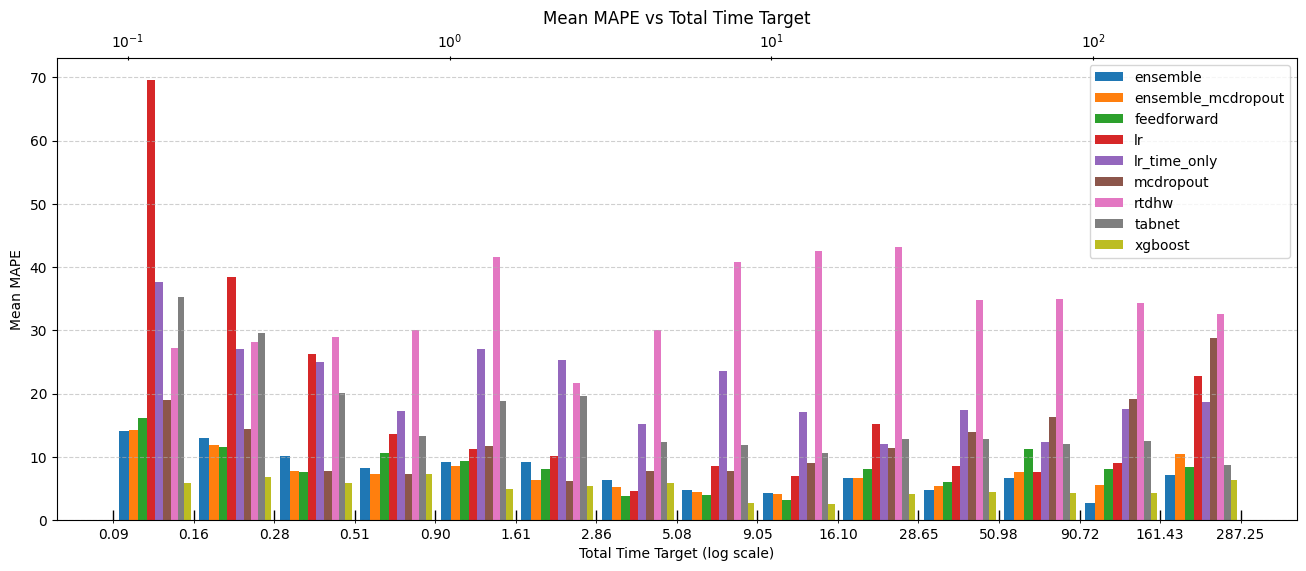

In [7]:
plot_errors(dfs, figsize=(16,6))
plot_errors(dfs, log_scale=True, figsize=(16,6))

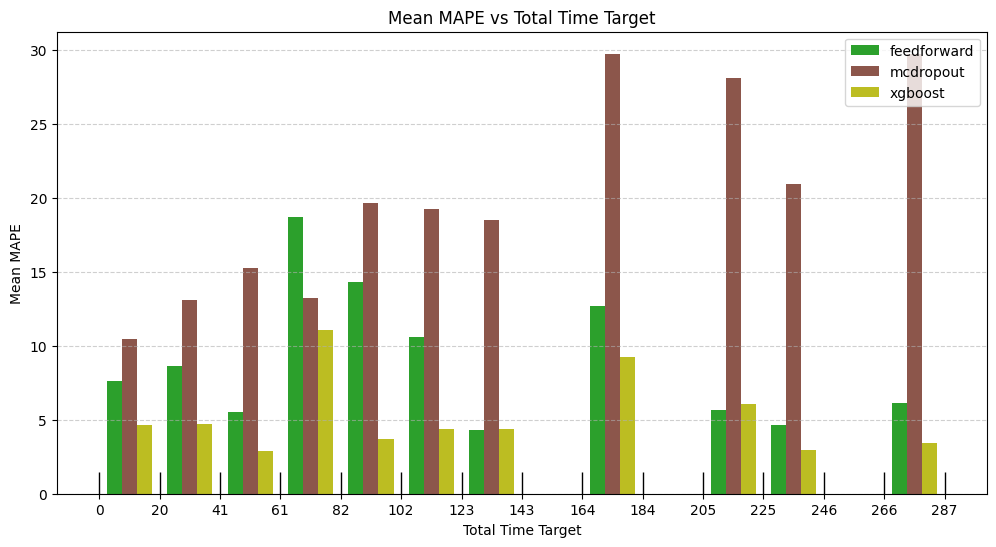

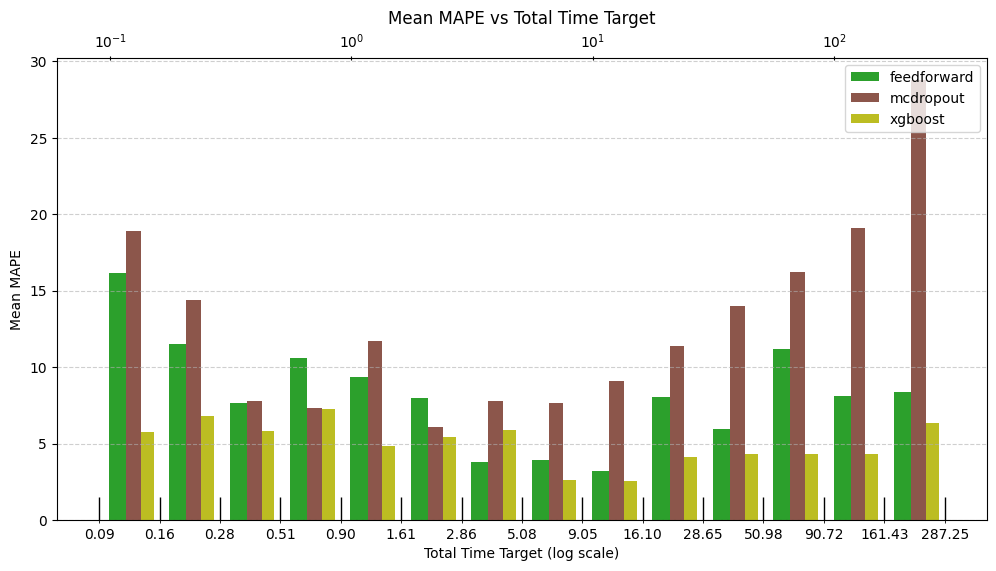

In [8]:
plot_errors(dfs, models=["xgboost", "feedforward", "mcdropout"])
plot_errors(dfs, models=["xgboost", "feedforward", "mcdropout"], log_scale=True)

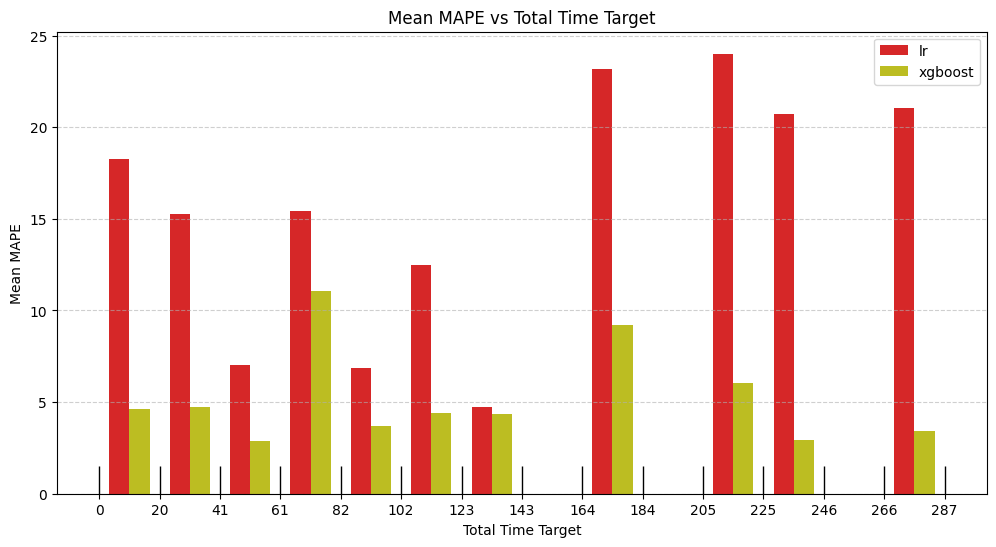

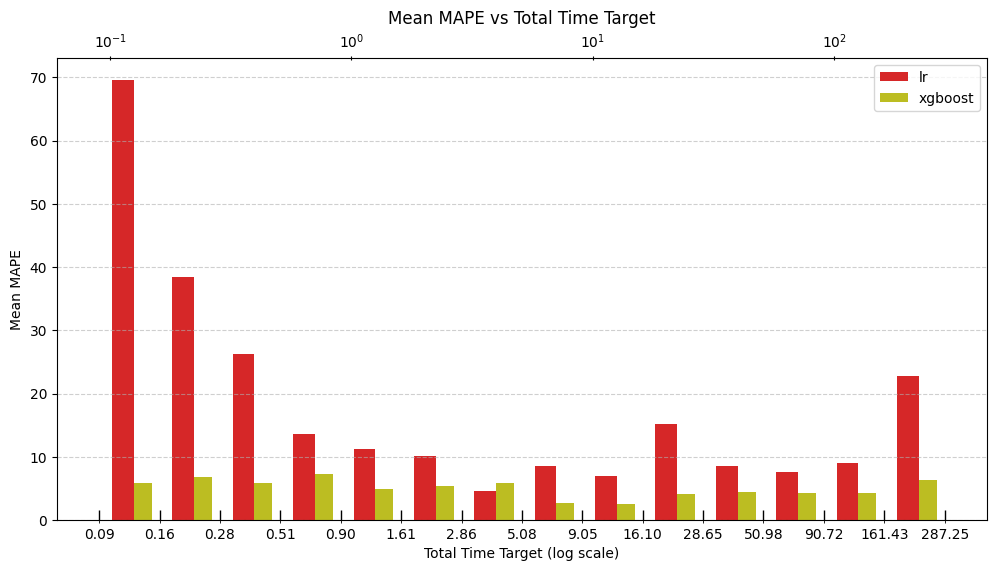

In [9]:
plot_errors(dfs, models=["xgboost", "lr"])
plot_errors(dfs, models=["xgboost", "lr"], log_scale=True)

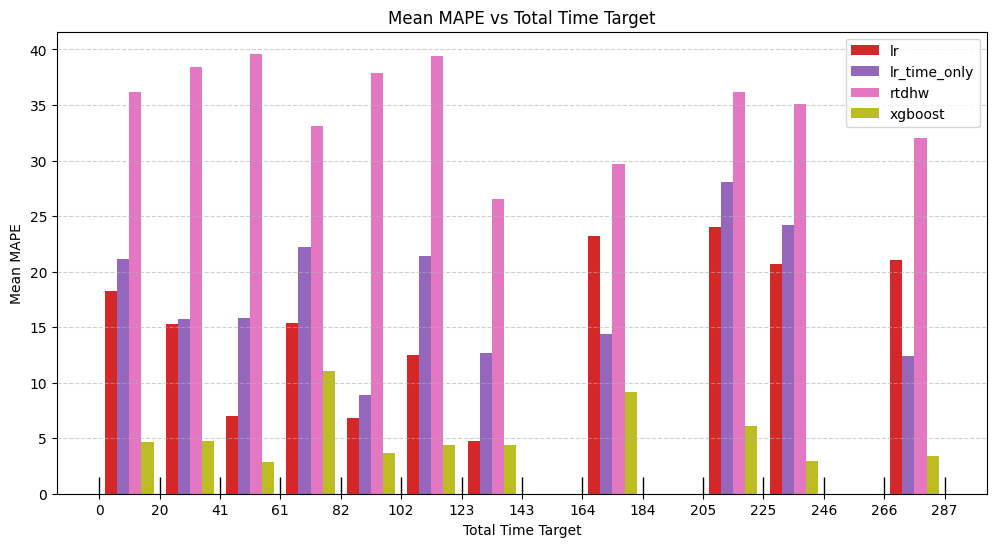

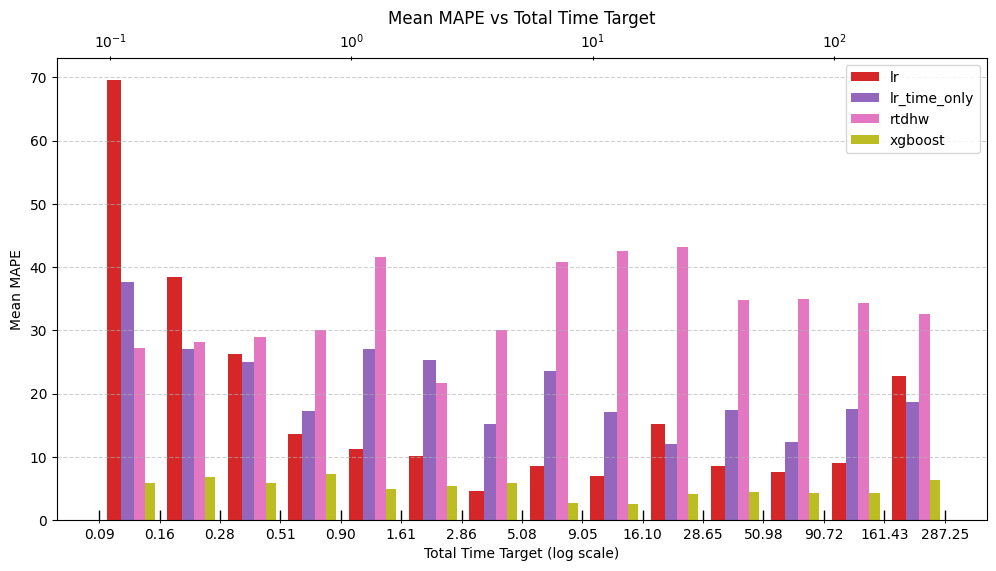

In [10]:
plot_errors(dfs, models=["xgboost", "rtdhw","lr", "lr_time_only"])
plot_errors(dfs, models=["xgboost", "rtdhw","lr", "lr_time_only"], log_scale=True)

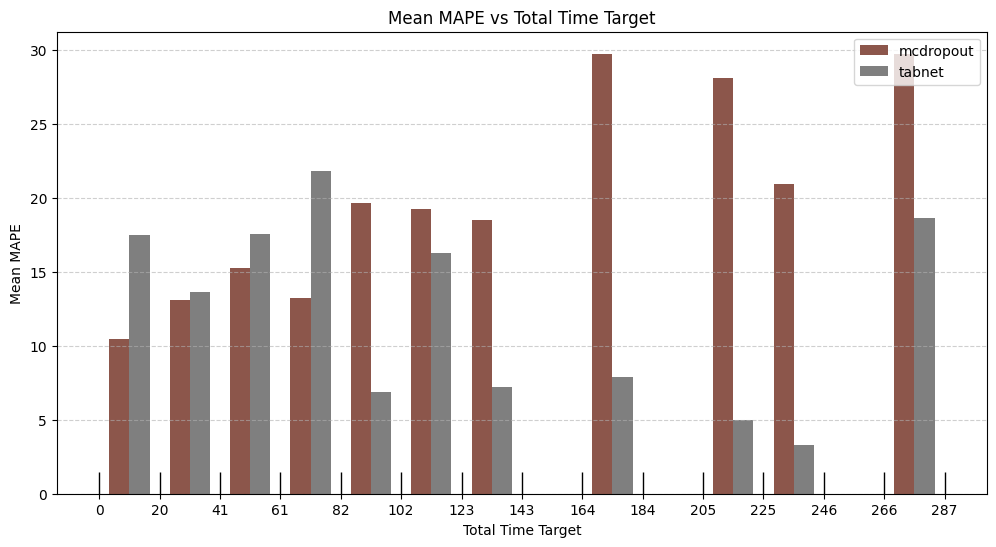

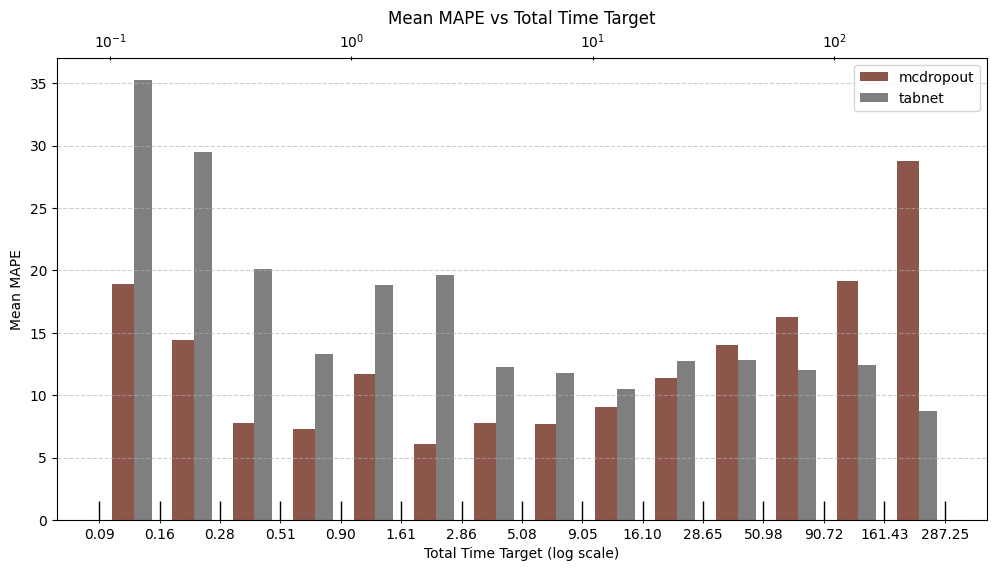

In [11]:
plot_errors(dfs, models=["mcdropout", "tabnet"])
plot_errors(dfs, models=["mcdropout", "tabnet"], log_scale=True)

# Only with high correlation variables

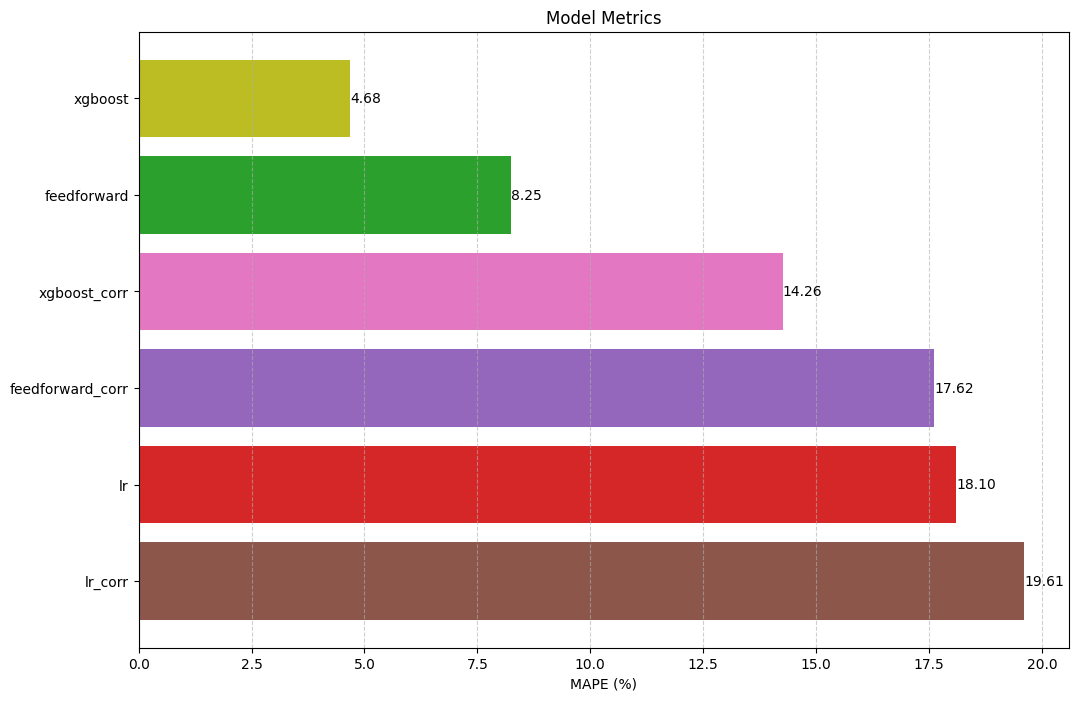

In [15]:
metrics = calculate_metrics(dfs_corr)
plot_MAPE(metrics, std=False)

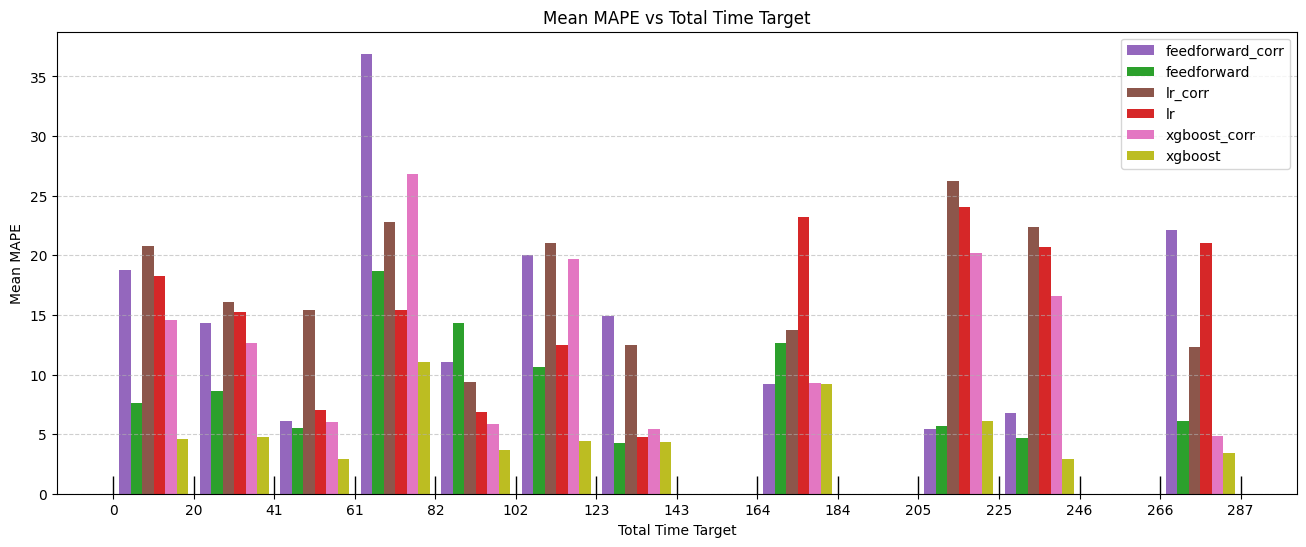

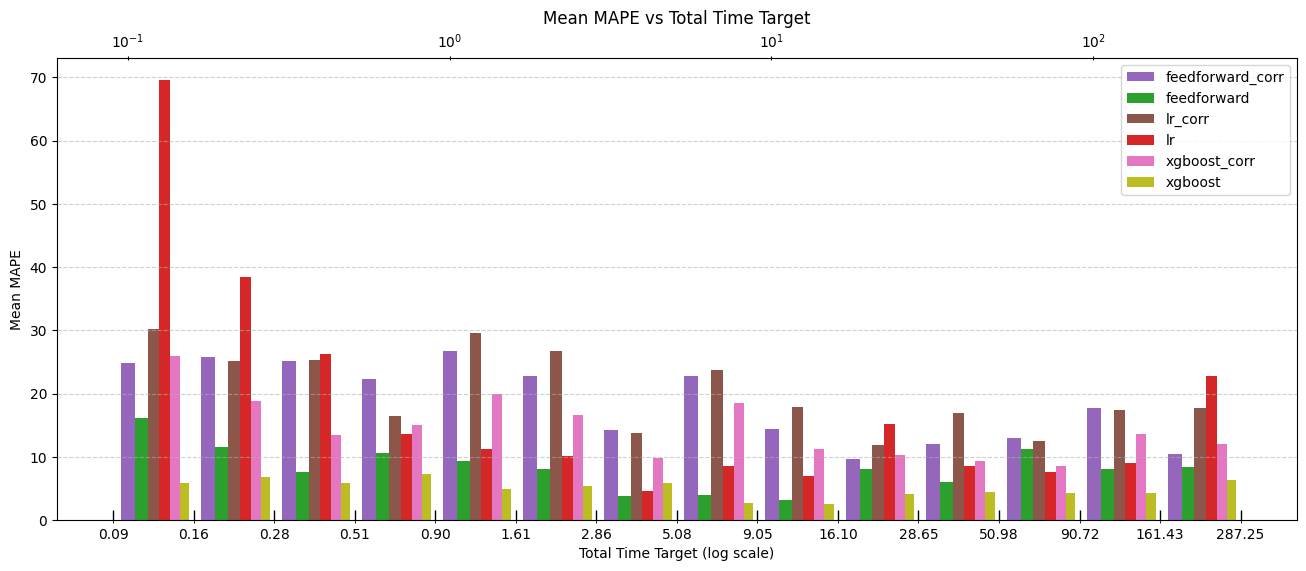

In [16]:
plot_errors(dfs_corr, figsize=(16,6))
plot_errors(dfs_corr, log_scale=True, figsize=(16,6))